<a href="https://colab.research.google.com/github/mbk-dev/okama/blob/master/examples/09%20forecasting.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

In [ ]:
!pip install okama

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12.0, 6.0]

import okama as ok

*okama* has several methods to forecast portfolio perfomance:
- according to historical data (without distribution models)
- according to normal distribution
- according to lognormal distribution

### Testing distribution

Before we use normal or lognormal distribution models, we should test the portfolio returns historical distribution and see if it fits.  
There is a notebook dedicated to backtesting distributions.

In [3]:
ls = ["GLD.US", "SPY.US", "VNQ.US", "AGG.US"]
al = ok.AssetList(ls, inflation=False)
al

assets           [GLD.US, SPY.US, VNQ.US, AGG.US]
currency                                      USD
first_date                                2004-12
last_date                                 2025-06
period_length                  20 years, 7 months
inflation                                    None
dtype: object

In [4]:
al.names

{'GLD.US': 'SPDR® Gold Shares',
 'SPY.US': 'SPDR S&P 500 ETF Trust',
 'VNQ.US': 'Vanguard Real Estate Index Fund ETF Shares',
 'AGG.US': 'iShares Core U.S. Aggregate Bond ETF'}

In [31]:
al.kstest(distr="norm")

,GLD.US,SPY.US,VNQ.US,AGG.US
statistic,0.052705,0.085132,0.075341,0.069464
p-value,0.482624,0.052524,0.115044,0.175877


In [32]:
al.kstest(distr="lognorm")

c:\Users\Komov\miniconda3\envs\py13\Lib\site-packages\scipy\stats\_continuous_distns.py:6912: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


,GLD.US,SPY.US,VNQ.US,AGG.US
statistic,0.051467,0.087434,0.077021,0.074792
p-value,0.513174,0.043076,0.101255,0.119874


We see that at least SPY is failed zero hypothesis  (didn't match 5% threshold) for both normal and lognormal distributions.  
But AGG has distribution close to normal. For GLD lognormal fits slightly better.  

Now we can construct the portfolio.

In [33]:
weights = [0.20, 0.10, 0.10, 0.60]
pf = ok.Portfolio(ls, ccy="USD", weights=weights, inflation=False)
pf

symbol                                      portfolio_4695.PF
assets                       [GLD.US, SPY.US, VNQ.US, AGG.US]
weights                                  [0.2, 0.1, 0.1, 0.6]
rebalancing_period                                      month
rebalancing_abs_deviation                                None
rebalancing_rel_deviation                                None
currency                                                  USD
inflation                                                None
first_date                                            2004-12
last_date                                             2025-06
period_length                              20 years, 7 months
dtype: object

In [34]:
pf.table

,asset name,ticker,weights
0,SPDR® Gold Shares,GLD.US,0.2
1,SPDR S&P 500 ETF Trust,SPY.US,0.1
2,Vanguard Real Estate Index Fund ETF Shares,VNQ.US,0.1
3,iShares Core U.S. Aggregate Bond ETF,AGG.US,0.6


In [35]:
pf.kstest(distr="norm")

{'statistic': np.float64(0.053780941301312),
 'p-value': np.float64(0.45680115819892686)}

In [36]:
pf.kstest(distr="lognorm")

c:\Users\Komov\miniconda3\envs\py13\Lib\site-packages\scipy\stats\_continuous_distns.py:6912: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


{'statistic': np.float64(0.07275661495944344),
 'p-value': np.float64(0.13925219911079323)}

 As expected Kolmogorov-Smirnov test shows that normal distribution fits much better. AGG has 60% weight in the allocation.

### Forecasting

The most intuitive way to present forecasted portfolio performance is to use **plot_forecast** method to draw the accumulated return chart (historical return and forecasted data).  
It is possible to use arbitrary percentiles set (10, 50, 90 is a default attribute value).  

Maximum forecast period is limited with 1/2 historical data period. For example, if the historical data period is 10 years, it's possible to use forecast periods up to 5 years.

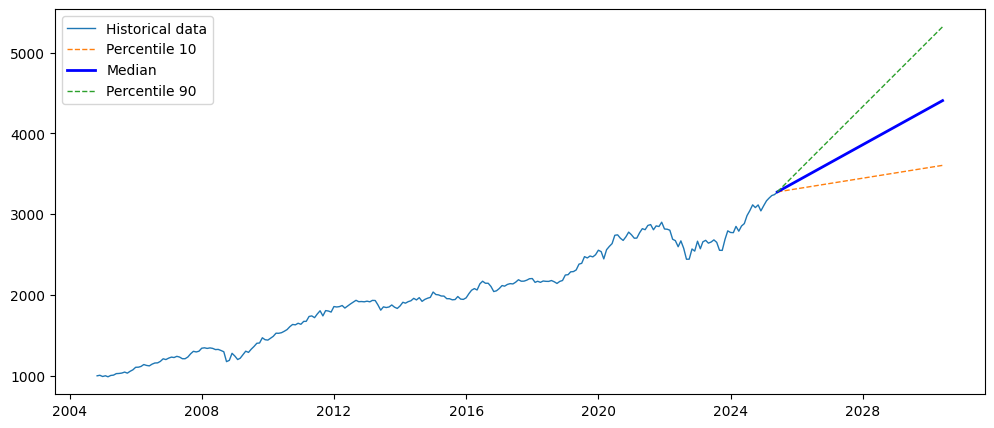

In [37]:
pf.plot_forecast(distr="norm", years=5, figsize=(12, 5));

Another way to visualize the normally distributed random forecasted data is with Monte Carlo simulation ...

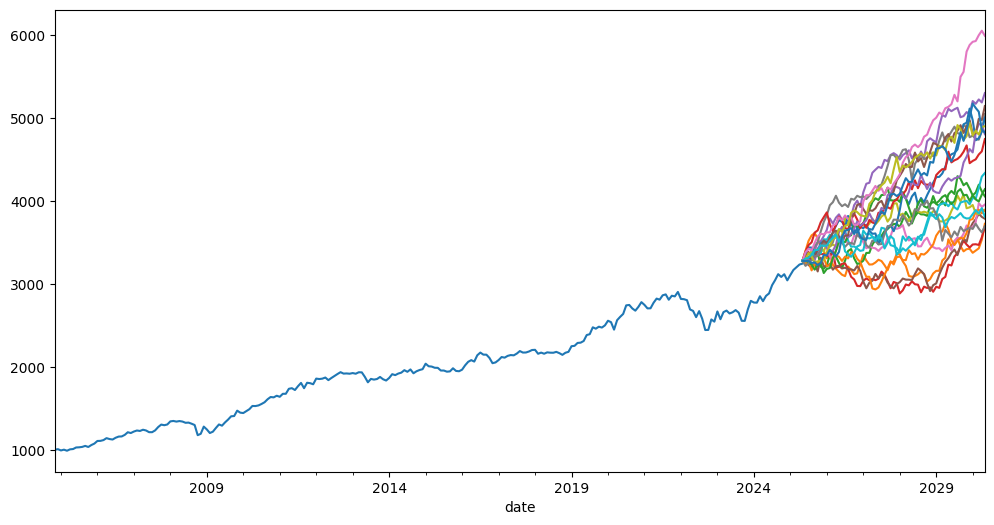

In [38]:
pf.plot_forecast_monte_carlo(
    distr="norm", years=5, n=20
)  # Generates 20 forecasted wealth indexes (for random normally distributed returns time series)

We can get numeric CAGR percentiles for each period with **percentile_distribution_cagr** method. To get credible forecast results high n values should be used.

In [39]:
pf.percentile_distribution_cagr(distr="norm", years=5, percentiles=[1, 20, 50, 80, 99], n=10000)

{1: np.float64(-0.013184319063682287),
 20: np.float64(0.03286953819231906),
 50: np.float64(0.059143098639490854),
 80: np.float64(0.08649503846319107),
 99: np.float64(0.13620621977066247)}

The same could be used to get VAR (Value at Risk):

In [40]:
pf.percentile_distribution_cagr(
    distr="norm", years=1, percentiles=[1], n=10000
)  # 1% percentile corresponds to 99% confidence level

{1: np.float64(-0.09468827530120186)}

One-year VAR (99% confidence level) is equal to 8%. It's a fair value for conservative portfolio.  
The probability of getting negative result in forecasted period is the percentile rank for zero CAGR value (score=0).

In [41]:
pf.percentile_inverse_cagr(distr="norm", years=1, score=0, n=10000)  # one year period

np.float64(19.6)

### Lognormal distribution

Some financial assets returns have returns distribution close to lognormal.  
The same calculations could be repeated for lognormal distribution by setting dist='lognorm'.

In [42]:
ln = ok.Portfolio(["EDV.US"], inflation=False)
ln

symbol                        portfolio_6128.PF
assets                                 [EDV.US]
weights                                   [1.0]
rebalancing_period                        month
rebalancing_abs_deviation                  None
rebalancing_rel_deviation                  None
currency                                    USD
inflation                                  None
first_date                              2008-01
last_date                               2025-06
period_length                17 years, 6 months
dtype: object

In [43]:
ln.names

{'EDV.US': 'Vanguard Extended Duration Treasury Index Fund ETF Shares'}

We can visualize the distribution and compare it with the lognormal PDF (Probability Distribution Function).

c:\Users\Komov\miniconda3\envs\py13\Lib\site-packages\scipy\stats\_continuous_distns.py:6912: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


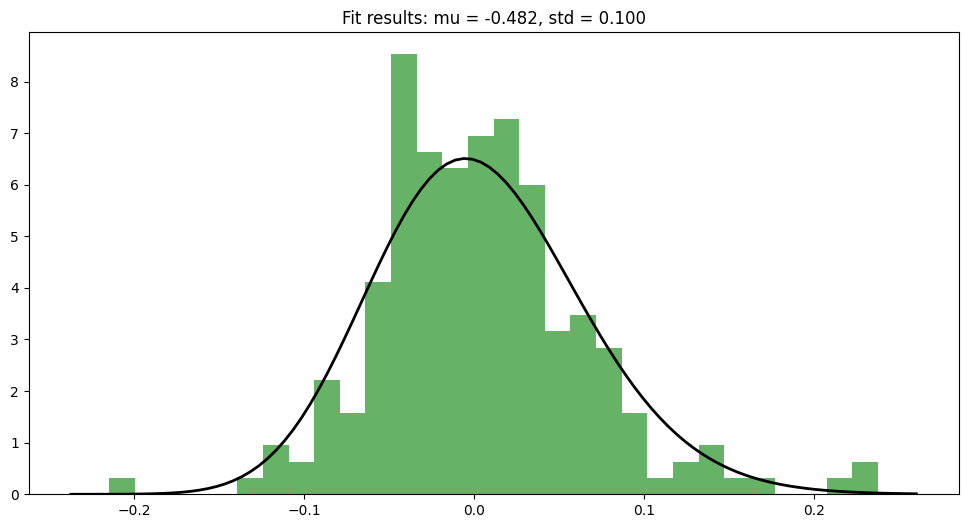

In [44]:
ln.plot_hist_fit(distr="lognorm", bins=30)

In [45]:
ln.kstest(distr="norm")  # Kolmogorov-Smirnov test for normal distribution

{'statistic': np.float64(0.06181701531343786),
 'p-value': np.float64(0.3829652880177108)}

In [46]:
ln.kstest(distr="lognorm")  # Kolmogorov-Smirnov test for lognormal distribution

{'statistic': np.float64(0.055053847231119724),
 'p-value': np.float64(0.5295396090275438)}

What is more important Kolmogorov-Smirnov test shows that historical distribution is slightly closer to lognormal.  
Therefore, we can use lognormal distribution to forecast.

c:\Users\Komov\miniconda3\envs\py13\Lib\site-packages\scipy\stats\_continuous_distns.py:6912: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


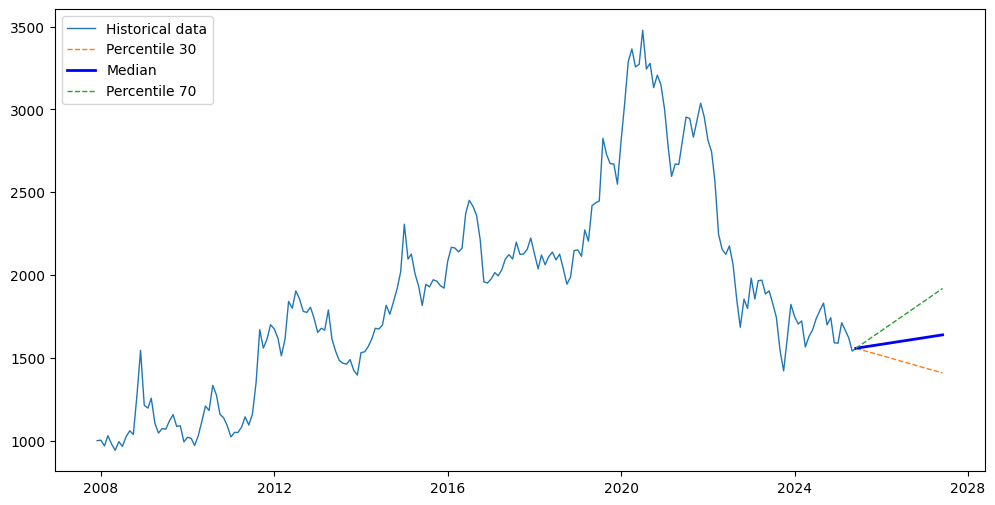

In [47]:
ln.plot_forecast(distr="lognorm", percentiles=[30, 50, 70], years=2, n=10000);

In [48]:
pf.percentile_distribution_cagr(distr="lognorm", years=1, percentiles=[1, 20, 50, 80, 99], n=10000)

c:\Users\Komov\miniconda3\envs\py13\Lib\site-packages\scipy\stats\_continuous_distns.py:6912: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


{1: np.float64(-0.0978402143353493),
 20: np.float64(-0.003706557251592523),
 50: np.float64(0.057549090206353126),
 80: np.float64(0.1261120293538755),
 99: np.float64(0.2587239038715663)}

### Forecasting using historical data

If it's not possible to fit the data to normal or lognormal distributions, percentiles from the historical data could be used.

In [49]:
ht = ok.Portfolio(["SPY.US"])
ht

symbol                        portfolio_8356.PF
assets                                 [SPY.US]
weights                                   [1.0]
rebalancing_period                        month
rebalancing_abs_deviation                  None
rebalancing_rel_deviation                  None
currency                                    USD
inflation                              USD.INFL
first_date                              1993-02
last_date                               2025-05
period_length                32 years, 4 months
dtype: object

In [50]:
ht.kstest("norm")

{'statistic': np.float64(0.0684357501890106),
 'p-value': np.float64(0.050357485809574554)}

In [51]:
ht.kstest("lognorm")

c:\Users\Komov\miniconda3\envs\py13\Lib\site-packages\scipy\stats\_continuous_distns.py:6912: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


{'statistic': np.float64(0.06682583815369902),
 'p-value': np.float64(0.059706626248449246)}

Kolmogorov-Smirnov test is not passing 5% threshold...

Big deviation in the tails could be seen in Quantile-Quantile Plot.

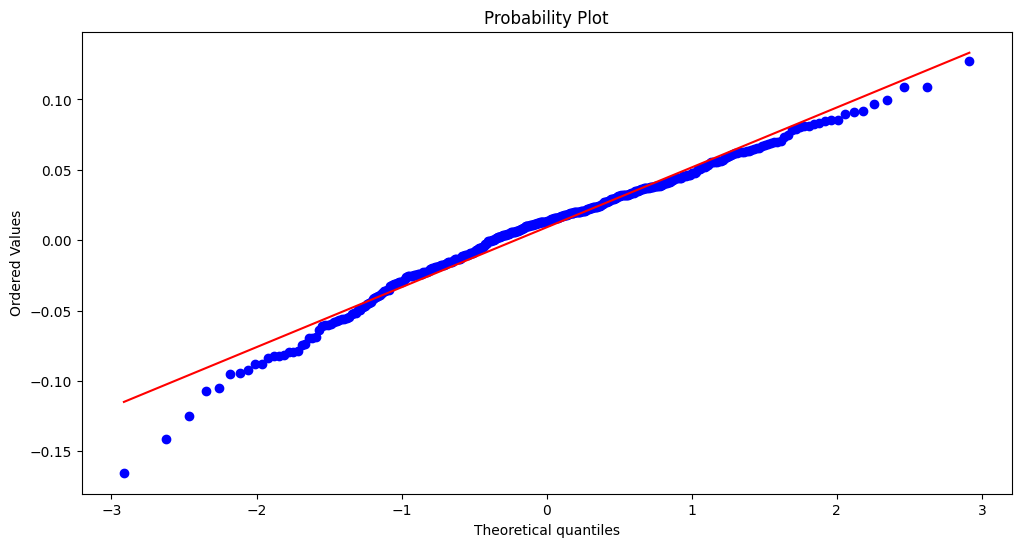

In [52]:
ht.plot_percentiles_fit("norm")

Then we can use percentiles from the historical data to forecast.

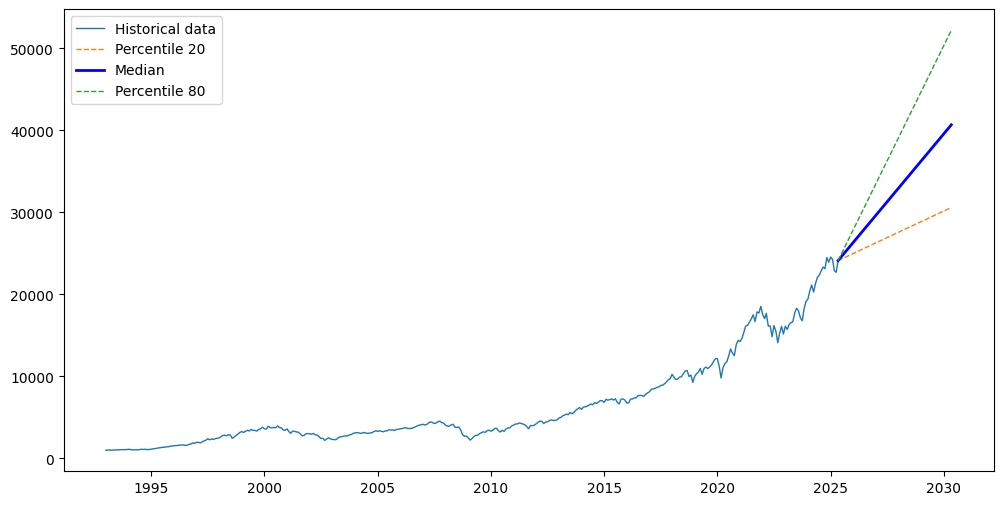

In [53]:
ht.plot_forecast(years=5, percentiles=[20, 50, 80]);

In [54]:
ht.percentile_wealth(distr="hist", years=5)

{10: 22719.989055815586, 50: 40735.16957189342, 90: 60695.13735204857}

Quantitative CAGR percentiles could be obtained from **percentile_history_cagr** method:

In [55]:
ht.percentile_history_cagr(years=5)

,10,50,90
years,,,
1,-0.117617,0.137599,0.301355
2,-0.089124,0.120707,0.256568
3,-0.057585,0.118163,0.233167
4,-0.037259,0.123195,0.222408
5,-0.011941,0.110440,0.202630


We can visualize the same to see how CAGR ranges were narrowing with investment horizon.

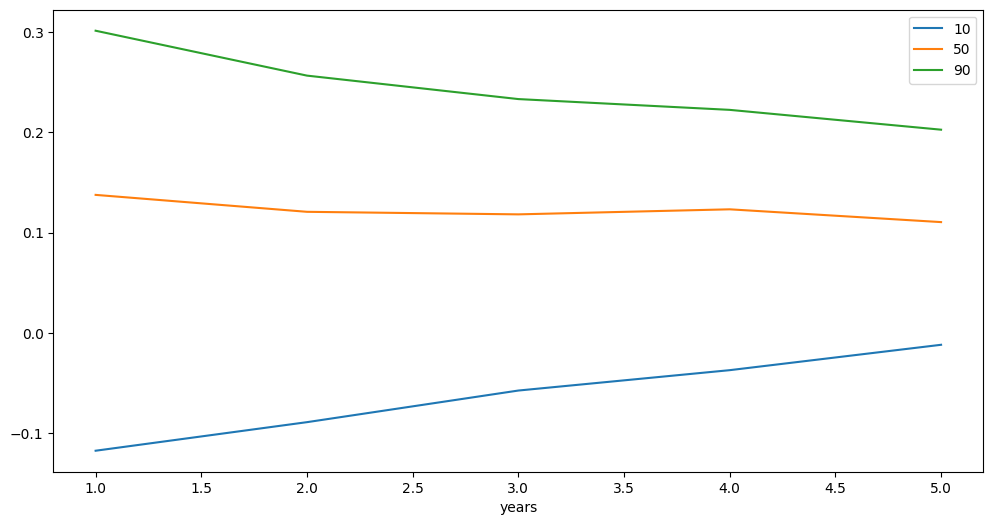

In [56]:
ht.percentile_history_cagr(years=5).plot();